# **IMPORT**

In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import pickle
import time
from skimage.measure import compare_ssim
import tensorflow as tf
from keras.models import Model,load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.utils import to_categorical
import keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
np.random.seed(0)

# **GLOBAL VARIABLES**

Values given in the paper


In [0]:
INDIVIDUALS = 50
P_CROSS = 0.6
P_MUTATION = 0.01
MNIST_IMG = 28

# **THE DATA**

1. MNIST

Pre-processing necessary before training the network

In [4]:
# load mnist
(x_train, y), (x_test, y_t) = tf.keras.datasets.mnist.load_data()

# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])
print('y_train shape:', y.shape)
print('y_test shape:', y_t.shape)


11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000
y_train shape: (60000,)
y_test shape: (10000,)



# **READY PICKLE FILE**

Pre-processed data 

In [0]:
with open('subset', 'rb') as f:
    original = pickle.load(f)
    adversarial= pickle.load(f)
    original_y = pickle.load(f)
    adversarial_y = pickle.load(f)

In [6]:
print(f"Original shape {original.shape}")
print(f"Adversarial shape {adversarial.shape}")
print(f"Original labels shape {original_y.shape}")
print(f"Adversarial labels shape {adversarial_y.shape}")

Original shape (895, 784)
Adversarial shape (126, 784)
Original labels shape (895,)
Adversarial labels shape (126,)


Normalize images

In [0]:
#adversarial = adversarial / 255.0

Original images

Label 0


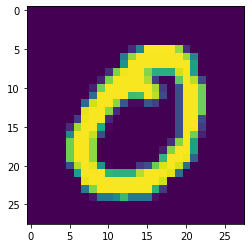

In [7]:
print("Original images\n")
plt.imshow(original[0].reshape(28,28))
print(f"Label {original_y[0]}")

In [0]:
original[0]

Adversarial images

Label 0


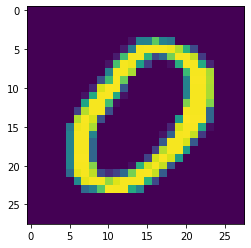

In [0]:
print("Adversarial images\n")
plt.imshow(adversarial[0].reshape(28,28))
print(f"Label {adversarial_y[0]}")

In [0]:
adversarial[0]

# **LOAD/TRAIN MODEL**

1. SVM

In [0]:
'''svm = SVC(C=1, kernel='rbf')
svm.fit(X, y)
svm.score(X_t, y_t)
save_model(svm)
'''

# first ran the function downstairs to initialize load_trained_model

model = load_trained_model("SVC_model.sav")


2. Original CNN

The network from Petra's 2020 paper, from the Appendix. This network is used for training MNIST, and has training accuracy 0.9871, test accuracy 0.9907 . 

In [9]:
# change labels to categorical before training
num_classes=10
y_train = to_categorical(y, num_classes)
y_test = to_categorical(y_t, num_classes)

# CNN from the Appendix of the 2020 paper 


inp = Input(shape=input_shape)
conv1 = Conv2D(32, (3,3),activation='relu')(inp)
conv2 = Conv2D(32, (3,3),activation='relu')(conv1)
max_pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop = Dropout(0.25)(max_pool1)
flat =  Flatten()(drop)
dense1 = Dense(128,activation="relu")(flat)
drop = Dropout(0.5)(dense1)
predictions = Dense(10,activation="softmax")(drop) # softmax layer 
model = Model(inputs=[inp], outputs=[predictions])

model.summary() 

model.compile(optimizer='Adadelta', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

'''
history = model.fit(x=x_train,y=y_train, epochs=10, validation_data=[x_test,y_test])

score= model.evaluate(x_test, y_test,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

'''
'''
model.save_weights("CNN_MNIST.h5")
model.save("MNIST_CNN.h5")
'''


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5899

'\nmodel.save_weights("CNN_MNIST.h5")\nmodel.save("MNIST_CNN.h5")\n'

In [0]:

model = load_model("MNIST_CNN.h5")


# **OPERATOR FUNCTIONS**

In [30]:

'''
def euclidean(s):
    # https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

def euc_fitness(individual, target, pred, label, l1=0.5, l2=0.5, N = 50, n_classes=10):
    # petras fitness fucntion
    return -(l1*euclidean(individual-target)/N + l2*euclidean(pred-label)/n_classes)
'''

def computing_SSIM(individual,target):
    return compare_ssim(individual.reshape(MNIST_IMG,MNIST_IMG), target.reshape(MNIST_IMG,MNIST_IMG))

def calculate_fitness(model,ind,target_image,label,l1=0.8, l2=0.2, N=50, num_classes=10):
  # predict the population
  predictions=model.predict(ind.reshape(1,MNIST_IMG,MNIST_IMG,1) / 255.0)  
  # po is the ground truth prediction, so for label = 0, it will be prediciton[0]
  predictions=predictions[0]
  po=predictions[label]
  # set that value to 0
  predictions[label]=0
  # take next highest one
  pd = np.max(predictions)
  diff=pd-po
  return l1*computing_SSIM(ind.reshape(MNIST_IMG,MNIST_IMG) ,target_image.reshape(MNIST_IMG,MNIST_IMG)) +l2*(diff)


def pop_fitness(model,pop,target,label):
    return [calculate_fitness(model, p, target, label) for p in pop]

def flatten(imgs):
    # flatten all images in np array or list
    return np.array([im.flatten() for im in imgs])

def gaussian_noise():
    # draw one sample of noise from zero mean 1 variance Gaussian
    # return np.random.normal(0, np.sqrt(0.01))
    return np.random.normal(0, 20)

def p_noise(x):
  if 0.01 > np.random.uniform():
    return x + gaussian_noise()
  else:
    return x
    
def add_noise(image):
    noise_v=np.vectorize(p_noise)
    return noise_v(image) #np.array([x + gaussian_noise() if P_MUTATION > np.random.uniform(0.0, 1.0) else x+0 for x in image])

def k_crossover(im1, im2, k=2):
    c1, c2 = [], []
    # get k crossover points
    points = sorted([np.random.randint(0, MNIST_IMG*MNIST_IMG-1, 1) for p in range(k)])
    points = sorted([np.random.randint(0,MNIST_IMG*MNIST_IMG-1,1) for p in range(k)])
    im_1_split = np.split(im1, [int(p) for p in points])
    im_2_split = np.split(im2, [int(p) for p in points])
    
    # alternate between lists to realise crossover (theres got to be a more clever way to do this)
    for i in range(k+1):
        if i % 2 == 0:
            c1.append(im_1_split[i])
            c2.append(im_2_split[i])
        else:
            c1.append(im_2_split[i])
            c2.append(im_1_split[i])
    return np.concatenate(c1, axis=0), np.concatenate(c2, axis=0)

def tournament(pop, model, ground_truth, target, k=3):

    indices = np.random.choice(range(len(pop)), k, replace=False) #we get 3 indxes [2 34 46]    
    individuals = pop.take(indices,axis=0)
    scores = pop_fitness(model,np.expand_dims(individuals.reshape(individuals.shape[0],MNIST_IMG,MNIST_IMG),axis=3), ground_truth.reshape(MNIST_IMG,MNIST_IMG), target)
    index_max = np.argmax(scores) #max(range(len(scores[0])), key=scores[0].__getitem__)
    winner = individuals[index_max]
    return winner

def check_adv_termination(ind, label,ground_truth, model):
  # individual - the best one from the generation
  # label - class we want
  # ground_truth - the image (28,28)
  # model we are using 
  dist = 1-compare_ssim(ind.reshape(MNIST_IMG,MNIST_IMG),ground_truth.reshape(MNIST_IMG,MNIST_IMG))
  predictions= model.predict(ind.reshape(1,MNIST_IMG,MNIST_IMG,1) / 255.0)
  predicted_label= np.argmax(predictions[0])
  if label != predicted_label and dist < 0.001:
    print("FOUND ADVERSARIAL")
    print(f"Fitness of the adversarial {calculate_fitness(model,ind,ground_truth,label)}")
    return individual
  return None 


def init_pop_from_sample(n,img,label):
    x = np.array([add_noise(img) for i in range(n)])
    return x.reshape(n, MNIST_IMG*MNIST_IMG)

'''
Cyrils model

def save_trained_model(model, filename='SVC_model.sav'):
    pickle.dump(model, open(filename, 'wb'))
    
def load_trained_model(filename='SVC_model.sav'):
    return pickle.load(open(filename, 'rb'))

def init_pop(n, num, data, labels):
    indices = np.where(labels==num)[0]
    n_indices = np.random.choice(indices, n, replace=True)
    sample = np.take(data, n_indices, axis=0)
    return sample, np.full((n), num, dtype=int) # return sample+array of labels

'''

'''
def check_adverserial(pop, model, fitness, target,ground_truth):
    #print(f"this is adversarial function")
    preds=model.predict(pop.reshape(pop.shape[0],28,28,1))
    #print(f"These are predictions made here {preds}")
    for ind, pr in zip(pop,preds): 
      #print(f"prediction for an individual {pr}")
      preds=np.argmax(pr)
      #print(f"getting the index of highest value in predictions {preds}")
      #setting the value to 0
      pr[0]=0
      #print(f"this is our target {target}")
      #print(f"this is out ground_truth {ground_truth.shape}")
      fitness=computing_SSIM(ind.reshape(28,28),ground_truth.reshape(28,28))
      #print(f"these are the fitness values {fitness}")
      next_highest = np.argmax(pr)
      #print(f"getting the next highest value {next_highest}")
      if next_highest != target and fitness > 0.98:
          return ind, True
      return None, False
'''

'\ndef check_adverserial(pop, model, fitness, target,ground_truth):\n    #print(f"this is adversarial function")\n    preds=model.predict(pop.reshape(pop.shape[0],28,28,1))\n    #print(f"These are predictions made here {preds}")\n    for ind, pr in zip(pop,preds): \n      #print(f"prediction for an individual {pr}")\n      preds=np.argmax(pr)\n      #print(f"getting the index of highest value in predictions {preds}")\n      #setting the value to 0\n      pr[0]=0\n      #print(f"this is our target {target}")\n      #print(f"this is out ground_truth {ground_truth.shape}")\n      fitness=computing_SSIM(ind.reshape(28,28),ground_truth.reshape(28,28))\n      #print(f"these are the fitness values {fitness}")\n      next_highest = np.argmax(pr)\n      #print(f"getting the next highest value {next_highest}")\n      if next_highest != target and fitness > 0.98:\n          return ind, True\n      return None, False\n'

In [0]:
''' my part of the code ''' 
''' I know it is ugly, I will fix it . this is the intial version'''
# from Goorge Clooney paper
def quadrant_crossover(parent_1,parent_2):

  # reshape parents
  parent_1,parent_2= parent_1.reshape((MNIST_IMG,MNIST_IMG)), parent_2.reshape((MNIST_IMG,MNIST_IMG))
  # quadrants for both parents
  p1,p2,p3,p4,q1,q2,q3,q4 = [],[],[],[],[],[],[],[]
  child1, child2 = [],[]
  # getting random (x,y) point in 2D matrix
  x,y = np.random.randint(0,MNIST_IMG-1), np.random.randint(0,MNIST_IMG-1)  

  # choose which quadrant we want to crossover
  N = np.random.randint(0,3)
  #make quadrants
  for i in range(MNIST_IMG):
    if (i<=x):
      p1.append(parent_1[i][:y+1])
      p2.append(parent_1[i][y+1:])
      q1.append(parent_2[i][:y+1])
      q2.append(parent_2[i][y+1:])
    else:
      p3.append(parent_1[i][:y+1])
      p4.append(parent_1[i][y+1:])
      q3.append(parent_2[i][:y+1])
      q4.append(parent_2[i][y+1:])

  if (N==0):
    ch1 = connect_quadrants(p1,q2,q3,q4)
    ch2 = connect_quadrants(q1,p2,p3,p4)
  elif (N==1):
    ch1 = connect_quadrants(q1,p2,q3,q4)
    ch2 = connect_quadrants(p1,q2,p3,p4)
  elif (N==2):
    ch1 = connect_quadrants(q1,q2,p3,q4)
    ch2 = connect_quadrants(p1,p2,q3,p4)
  else:
    ch1 = connect_quadrants(q1,q2,q3,p4)
    ch2 = connect_quadrants(p1,p2,p3,q4)

  return ch1,ch2

def connect_quadrants(q1,q2,q3,q4):
  left = np.concatenate((q1,q3))
  right = np.concatenate((q2,q4))
  image = np.concatenate((left,right),axis=1)
  return image.flatten()


def multi_crossover(parent1,parent2,target):
  pop= []
  # 2-k crossover
  pop.append(k_crossover(parent1, parent2))
  # Gorge Clooney crossover
  pop.append(quadrant_crossover(parent1,parent2))
  # uniform crossover
  pop.append(k_crossover(parent1, parent2,1))
  # SSIM similarity 
  flattened_list = [y for x in pop for y in x] # need to flatten the list because pop is list of lists, cause every crossover function returns 2 obj
  ssim = [computing_SSIM(ind,target) for ind in flattened_list ]
  # taking the index of largest two score
  id1=np.argmax(ssim)
  ssim[id1]=0
  id2 = np.argmax(ssim)
  #returning parents
  return flattened_list[id1],flattened_list[id2]
  


In [0]:
def return_best_individual(pop,fitness):
  index = np.argmax(fitness)
  best = pop[index]
  return best 

In [0]:
def choose_better_child(ch1, ch2,ground_truth,label,model):
  # I named it better child, but we choose by this parents as well
  ch1_f = calculate_fitness(model,ch1.reshape(MNIST_IMG,MNIST_IMG),ground_truth.reshape(MNIST_IMG,MNIST_IMG),label)
  ch2_f = calculate_fitness(model,ch2.reshape(MNIST_IMG,MNIST_IMG),ground_truth.reshape(MNIST_IMG,MNIST_IMG),label)
  # change this into ternary operator
  if ch1_f>ch2_f:
    return ch1
  else:
    return ch2              


# **THE MAIN FUNCTION**

Flatten data before evolving

In [0]:
'''
This not necessary when using subset 
'''
'''
X = flatten(x_train)
X_t = flatten(x_test)
print(f"X train shape {X.shape}")
print(f"X test shape {X_t.shape}")
print(f"y train shape {y.shape}")
print(f"y test shape {y_t.shape}")
'''

'\nX = flatten(x_train)\nX_t = flatten(x_test)\nprint(f"X train shape {X.shape}")\nprint(f"X test shape {X_t.shape}")\nprint(f"y train shape {y.shape}")\nprint(f"y test shape {y_t.shape}")\n'

# **MAIN FUNCTION**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


Generation 10
Max fitness value 0.5924031320365176


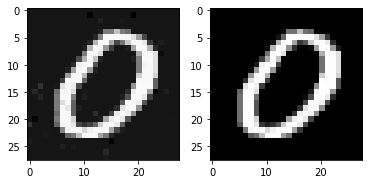

True label: 0
predicted label: 0
Generation 20
Max fitness value 0.5905882082250937


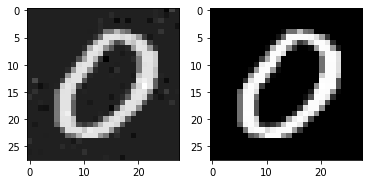

True label: 0
predicted label: 0
Generation 30
Max fitness value 0.5932587784834515


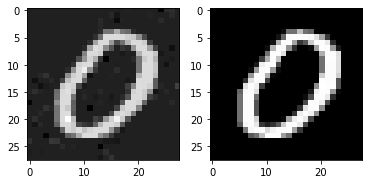

True label: 0
predicted label: 0
Generation 40
Max fitness value 0.5908643390329777


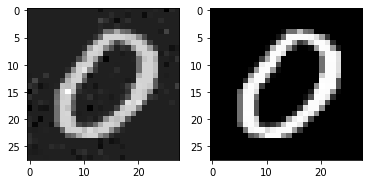

True label: 0
predicted label: 0
Generation 50
Max fitness value 0.590212229242658


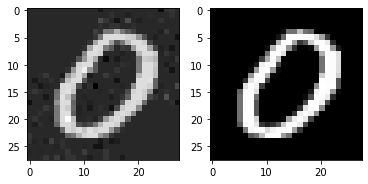

True label: 0
predicted label: 0
Generation 60
Max fitness value 0.5899997874005857


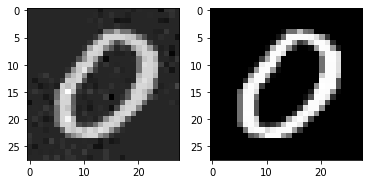

True label: 0
predicted label: 0
Generation 70
Max fitness value 0.5830384870359293


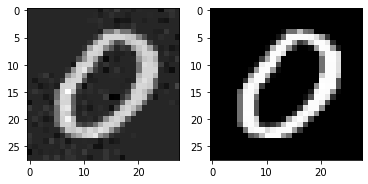

True label: 0
predicted label: 0
Generation 80
Max fitness value 0.5867455529826041


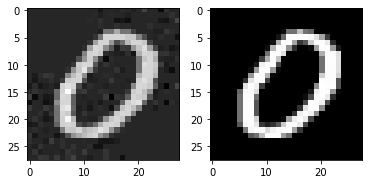

True label: 0
predicted label: 0
Generation 90
Max fitness value 0.5828472199511341


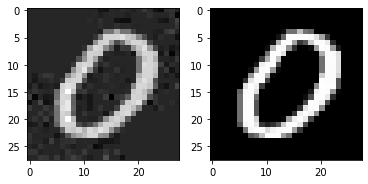

True label: 0
predicted label: 0
Generation 100
Max fitness value 0.5798173861297009


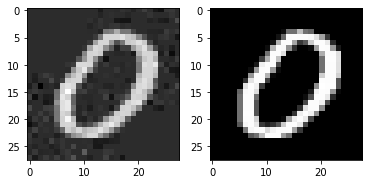

True label: 0
predicted label: 0
Generation 110
Max fitness value 0.5814117305708639


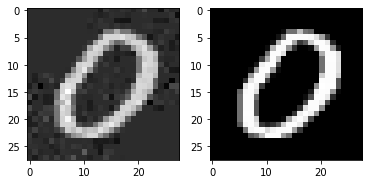

True label: 0
predicted label: 0
Generation 120
Max fitness value 0.5815856350086772


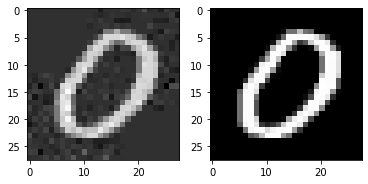

True label: 0
predicted label: 0
Generation 130
Max fitness value 0.5791285843881147


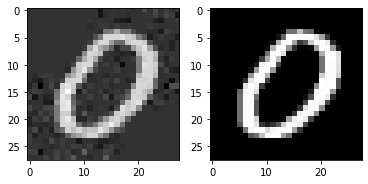

True label: 0
predicted label: 0
Generation 140
Max fitness value 0.5789646419494215


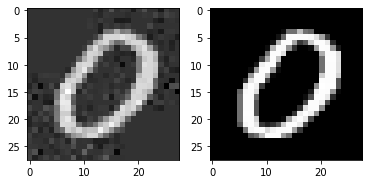

True label: 0
predicted label: 0
Generation 150
Max fitness value 0.5747718060829955


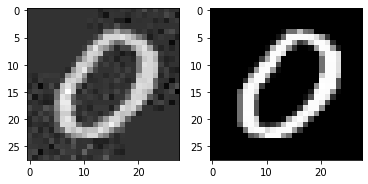

True label: 0
predicted label: 0
Generation 160
Max fitness value 0.5742828946676846


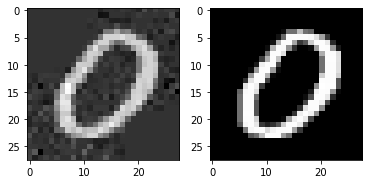

True label: 0
predicted label: 0
Generation 170
Max fitness value 0.5725505097511318


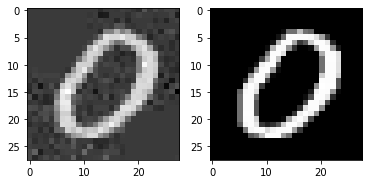

True label: 0
predicted label: 0
Generation 180
Max fitness value 0.5701954341410871


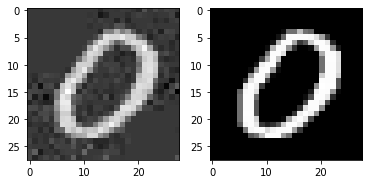

True label: 0
predicted label: 0
Generation 190
Max fitness value 0.5715474119706341


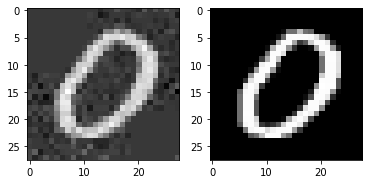

True label: 0
predicted label: 0
Generation 200
Max fitness value 0.5683740231468983


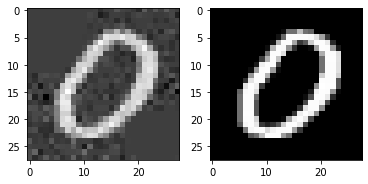

True label: 0
predicted label: 0
Generation 210
Max fitness value 0.5699515083444533


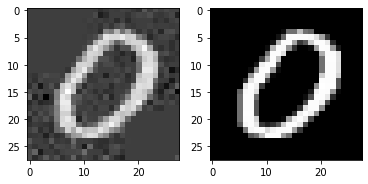

True label: 0
predicted label: 0
Generation 220
Max fitness value 0.5695762950061369


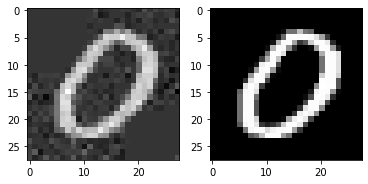

True label: 0
predicted label: 0
Generation 230
Max fitness value 0.5704869492724942


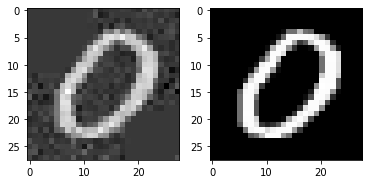

True label: 0
predicted label: 0
Generation 240
Max fitness value 0.5627085462026093


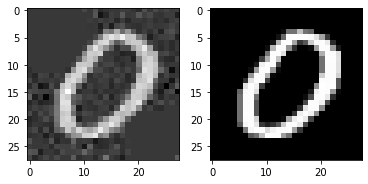

True label: 0
predicted label: 0
Generation 250
Max fitness value 0.5657707803177872


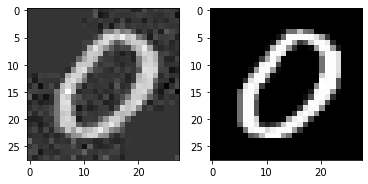

True label: 0
predicted label: 0
Generation 260
Max fitness value 0.5663252434659507


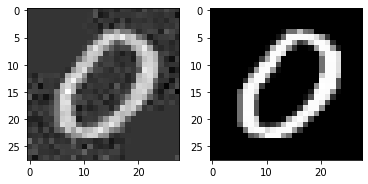

True label: 0
predicted label: 0
Generation 270
Max fitness value 0.5662980194859071


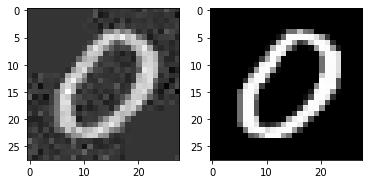

True label: 0
predicted label: 0
Generation 280
Max fitness value 0.5648276732880166


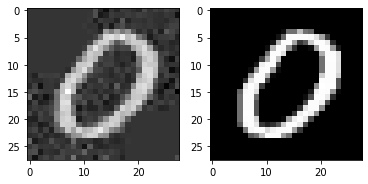

True label: 0
predicted label: 0
Generation 290
Max fitness value 0.5628959792815067


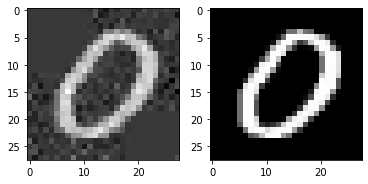

True label: 0
predicted label: 0
Generation 300
Max fitness value 0.5630531115776825


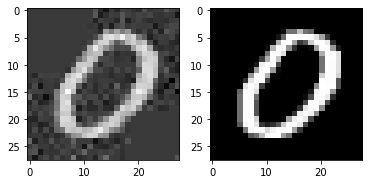

True label: 0
predicted label: 0
Generation 310
Max fitness value 0.5621070838518731


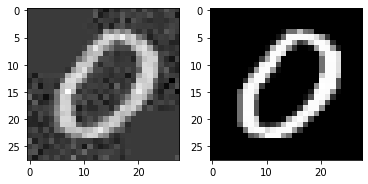

True label: 0
predicted label: 0
Generation 320
Max fitness value 0.5602918841085307


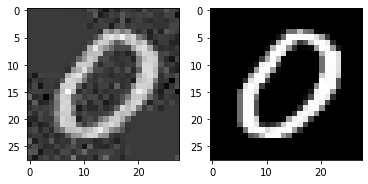

True label: 0
predicted label: 0
Generation 330
Max fitness value 0.5587429255593339


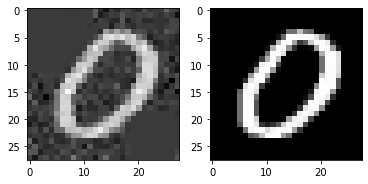

True label: 0
predicted label: 0
Generation 340
Max fitness value 0.5609453234921247


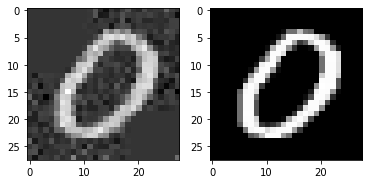

True label: 0
predicted label: 0
Generation 350
Max fitness value 0.5614357517698714


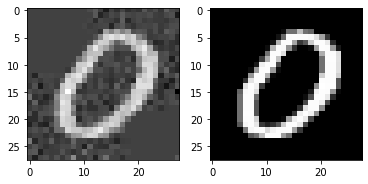

True label: 0
predicted label: 0
Generation 360
Max fitness value 0.5590785224964665


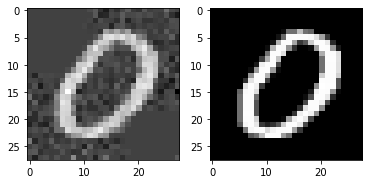

True label: 0
predicted label: 0
Generation 370
Max fitness value 0.5582077325369614


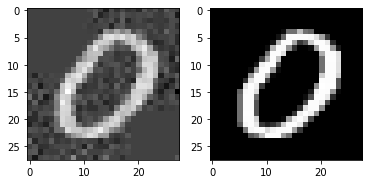

True label: 0
predicted label: 0
Generation 380
Max fitness value 0.5590559249292182


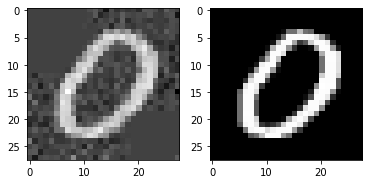

True label: 0
predicted label: 0
Generation 390
Max fitness value 0.555824803210708


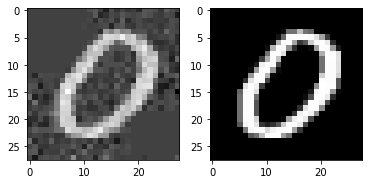

True label: 0
predicted label: 0
Generation 400
Max fitness value 0.5552271116749716


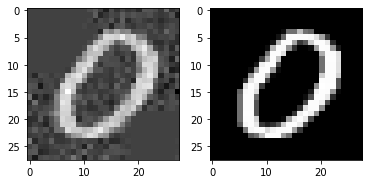

True label: 0
predicted label: 0
Generation 410
Max fitness value 0.5537813721820577


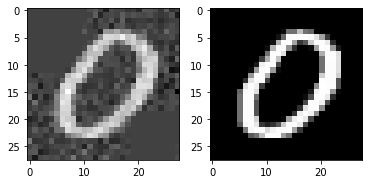

True label: 0
predicted label: 0
Generation 420
Max fitness value 0.5521380836876097


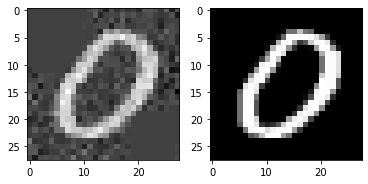

True label: 0
predicted label: 0
Generation 430
Max fitness value 0.5550303922394939


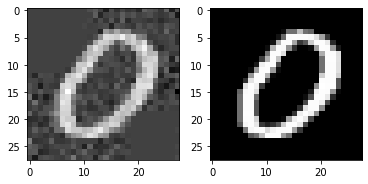

True label: 0
predicted label: 0
Generation 440
Max fitness value 0.554551900813703


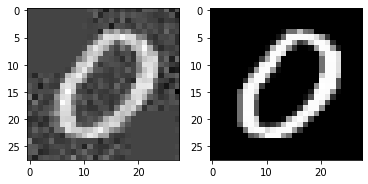

True label: 0
predicted label: 0
Generation 450
Max fitness value 0.5553803045241501


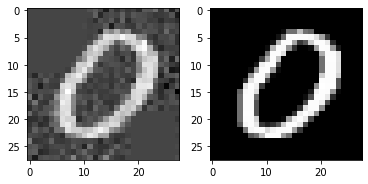

True label: 0
predicted label: 0
Generation 460
Max fitness value 0.5548284487540458


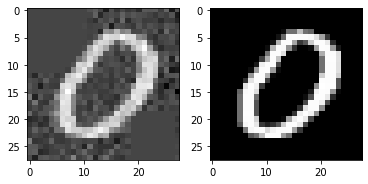

True label: 0
predicted label: 0
Generation 470
Max fitness value 0.5545976558552068


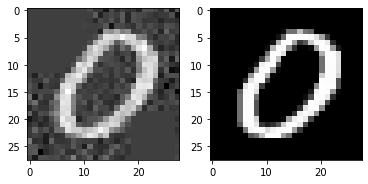

True label: 0
predicted label: 0
Generation 480
Max fitness value 0.5551434545666663


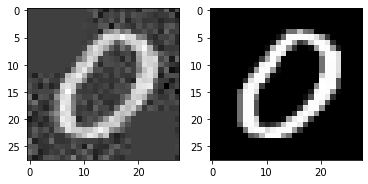

True label: 0
predicted label: 0
Generation 490
Max fitness value 0.5559372677773073


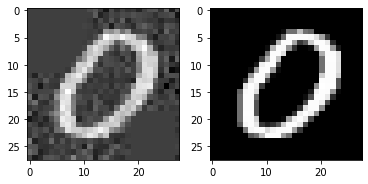

True label: 0
predicted label: 0
Generation 500
Max fitness value 0.5544862441689842


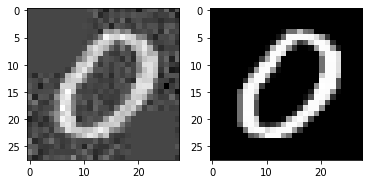

True label: 0
predicted label: 0
Generation 510
Max fitness value 0.5550693173306598


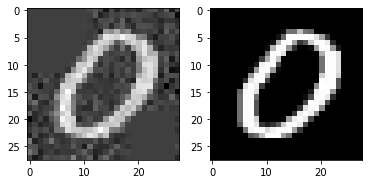

True label: 0
predicted label: 0
Generation 520
Max fitness value 0.5545328319573788


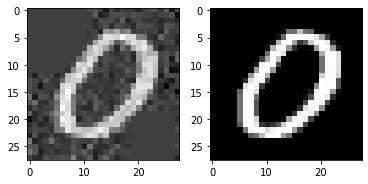

True label: 0
predicted label: 0
Generation 530
Max fitness value 0.555026002714732


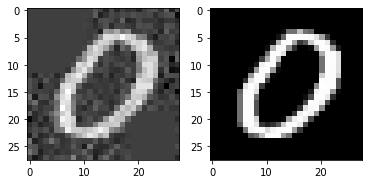

True label: 0
predicted label: 0
Generation 540
Max fitness value 0.5536541595460276


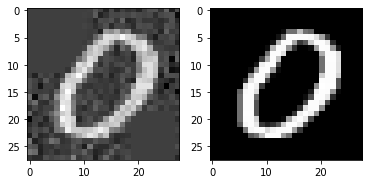

True label: 0
predicted label: 0
Generation 550
Max fitness value 0.5520368740504327


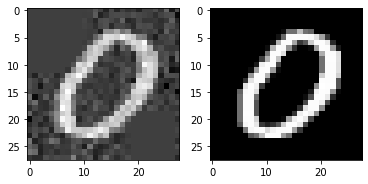

True label: 0
predicted label: 0
Generation 560
Max fitness value 0.5515295760044296


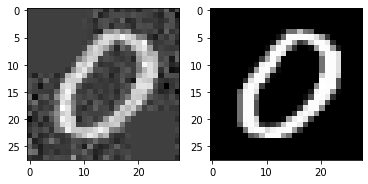

True label: 0
predicted label: 0
Generation 570
Max fitness value 0.5498123332660536


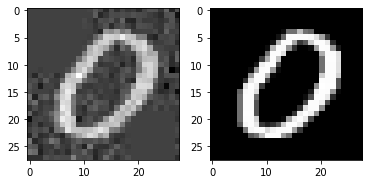

True label: 0
predicted label: 0


KeyboardInterrupt: ignored

In [34]:
# for each image and label in adversarial
n=50

# these are the examples that are found as adversarial
# we will save these at the end in a file
evolved_examples= []

for img,label in zip(adversarial,adversarial_y):
  #intialize population from the image and with the given label
  population = init_pop_from_sample(n,img,label)
  # calculate fitness of these individuals
  fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],MNIST_IMG,MNIST_IMG),axis=3),img.reshape(MNIST_IMG,MNIST_IMG),label)
  #retun the best one from the population
  best = return_best_individual(population,fitness)
  #check if adversarial
  check_adv = check_adv_termination(best,label,img, model)
  max_gen=0
  while (check_adv==None or max_gen<1000):
    new_pop=[]
    for i in range(50):
      parent1= tournament(population, model, img, label) 
      parent2 = tournament(population, model, img, label)
      if 0.6 > np.random.uniform(0.0, 1.0):
        child1, child2 = multi_crossover(parent1, parent2,img) # crossover
        new_pop.append(add_noise(choose_better_child(child1, child2,img,label,model)))
        #new_pop.append(add_noise(child1)) ## apply mutation to pixels 
        #new_pop.append(add_noise(child2))
      else:
        new_pop.append(add_noise(choose_better_child(parent1, parent2,img,label,model)))
        #new_pop.append(add_noise(parent1))
        #new_pop.append(add_noise(parent2))

    # to reshape into an array 
    population= np.array(new_pop)
    fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],MNIST_IMG,MNIST_IMG),axis=3),img.reshape(MNIST_IMG,MNIST_IMG),label) 
    max_gen+=1
    if (max_gen % 10 == 0):
      print(f"Generation {max_gen}")
      print(f"Max fitness value {np.max(fitness)}")
      index = np.argmax(fitness)
      fd, idx = plt.subplots(1,2)
      idx[0].imshow(population[index].reshape(MNIST_IMG,MNIST_IMG),cmap='gray')
      idx[1].imshow(img.reshape(MNIST_IMG,MNIST_IMG),cmap='gray')
      plt.show()
      print(f"True label: {label}")
      print(f"predicted label: {np.argmax(model.predict(population[index].reshape(1,MNIST_IMG,MNIST_IMG,1) / 255.0))}")
    #check if adversarial
    check_adv = check_adv_termination(best,label,img, model)

  #show adversarial
  
  if(adv != None):
    plt.imshow(adv.reshape(MNIST_IMG,MNIST_IMG))
  else:
    print(f" We came to {max_gen} th round")




# Examples of what functions do

Running one by one function

In [0]:
population = init_pop_from_sample(50,adversarial[34],adversarial_y[34])

In [0]:
itness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],MNIST_IMG,MNIST_IMG),axis=3),img.reshape(MNIST_IMG,MNIST_IMG),label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()


In [0]:
parent1 = tournament(population, model, adversarial[34], adversarial_y[34]) 
parent2 = tournament(population, model, adversarial[34], adversarial_y[34])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()


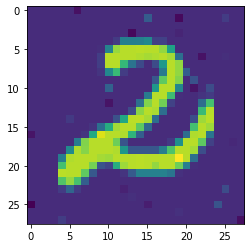

In [0]:
plt.imshow(parent1.reshape(MNIST_IMG,MNIST_IMG))
ff = calculate_fitness(model,parent1.reshape(MNIST_IMG,MNIST_IMG),adversarial[34].reshape(MNIST_IMG,MNIST_IMG),adversarial_y[34])

In [0]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(parent1.reshape(MNIST_IMG,MNIST_IMG))
idx[1].imshow(parent2.reshape(MNIST_IMG,MNIST_IMG))

In [0]:
parent1-parent2

In [0]:
child1, child2 = multi_crossover(parent1, parent2,adversarial[34]) # crossover 
#child1, child2 = add_noise(child1), add_noise(child2) # apply mutation to pixels 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()


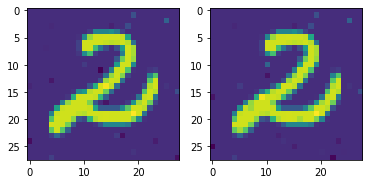

In [0]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(child1.reshape(MNIST_IMG,MNIST_IMG))
idx[1].imshow(child2.reshape(MNIST_IMG,MNIST_IMG))

In [0]:
bb = choose_better_child(child1, child2,adversarial[34],adversarial_y[34],model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()


In [0]:
a1=calculate_fitness(model,child1.reshape(MNIST_IMG,MNIST_IMG),adversarial[34].reshape(MNIST_IMG,MNIST_IMG),adversarial_y[34])
a2=calculate_fitness(model,child2.reshape(MNIST_IMG,MNIST_IMG),adversarial[34].reshape(MNIST_IMG,MNIST_IMG),adversarial_y[34])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()


In [0]:
fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],MNIST_IMG,MNIST_IMG),axis=3),img.reshape(MNIST_IMG,MNIST_IMG),label) 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()


1. Init population 

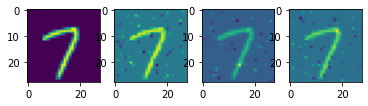

In [0]:
f, ax = plt.subplots(1,4)
ax[0].imshow(ground_truth.reshape(28,28))
ax[1].imshow(population[0].reshape(28,28))
ax[2].imshow(population[1].reshape(28,28))
ax[3].imshow(population[2].reshape(28,28))


2. Prediction and fitness functions


In [0]:
print(f"Population shape {population.shape}")
print(f"One sample from population shape {population[0].shape}")

Population shape (50, 784)
One sample from population shape (784,)


In [0]:
''' We need to expand the dimension because CNN requires (28,28,1) shape) '''
predictions = model.predict(np.expand_dims(population.reshape(population.shape[0],28,28),axis=3))
print("Example of predictions for 1st sample from population \n")
print(predictions[0])

Example of predictions for 1st sample from population 

[1.83606268e-08 1.87752196e-08 2.89226159e-06 2.00165414e-06
 5.12024805e-08 3.22582006e-09 6.12911588e-12 9.99759257e-01
 1.01414464e-07 2.35686341e-04]


Adversarial example

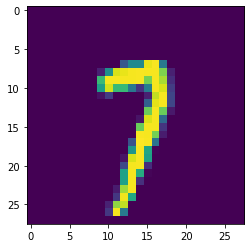

In [0]:
plt.imshow(adverserial.reshape(28,28))

In [0]:
model.predict(adverserial.reshape(1,-1))

array([7], dtype=uint8)

In [0]:
'''

Cyril's part

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, typecode="d", fitness=creator.FitnessMax, strategy=None)
creator.create("Strategy", np.ndarray, typecode="d")

tbx = base.Toolbox()
INDIVIDUAL_SIZE = 784


tbx.register("attr_int", random.randint, 0, 1)
tbx.register("individual", 
             tools.initRepeat, 
             creator.Individual,
             tbx.attr_int, 
             n=INDIVIDUAL_SIZE)
tbx.register("population", tools.initRepeat, list, tbx.individual)
tbx.register("evaluate", EOQ)
tbx.register("mate", tools.cxOnePoint)
tbx.register("mutate", tools.mutFlipBit, indpb=0.01)
tbx.register("select", tools.selTournament, tournsize=5)

'''

In [0]:
'''def ga(num, data, labels, max_gen, target, individuals = INDIVIDUALS, p_cross = P_CROSS, p_mut = P_MUTATION):
    
    # initialize population by drawing 1 sample from passed dataset, automatically applies noise to all copies
    # Then take predictions to calculate population fitness
    pop, ground_truth = init_pop_from_sample(individuals, num, data, labels)
    #predictions = model.predict(pop)
    fit_vals = calculate_fitness(model,pop, ground_truth, label)

    for gen in range(max_gen):
        if gen % 10 == 0:
            print(f'fitting gen: {gen}')
            print(fit_vals)

        adverserial = check_adverserial(pop, predictions, fit_vals, target)
        if adverserial:
            return adverserial
        
        new_pop = []
        for i in range(individuals//2):
                            
            parent1, idx1 = tournament_selection(pop, predictions, ground_truth, target) 
            parent2, idx2 = tournament_selection(pop, predictions, ground_truth, target)
            if p_cross > np.random.uniform(0.0, 1.0):
                
                #child1, child2 = np.array([]), np.array([])
                child1, child2 = multi_crossover(parent1, parent2) # crossover
                
                child1, child2 = add_noise(child1), add_noise(child2) # apply mutation to pixels     
                #if child1.size != 0:
                new_pop.append(child1)
                new_pop.append(child2)
            else:
                new_pop.append(parent1)
                new_pop.append(parent2)
            #print(len(pop))
            #pop.pop(idx1[0])
            #pop.pop(idx2[0])
            if idx1 != idx2:
                order = sorted([idx1, idx2], reverse = True)
                pop = np.delete(pop, order[0], axis=0)
                pop = np.delete(pop, order[1], axis=0)
            else:
                order = idx1
                pop = np.delete(pop, order, axis=0)

            print(order)
            print(pop.shape)

                
        pop = np.array(new_pop)
        predictions = model.predict(pop)
        fit_vals = pop_fitness(pop, ground_truth, predictions, target)
    return pop[fit_vals.index(max(fit_vals))]
    
start = time.process_time()
adverserial = ga(7, X, y, 1, 1) #(num, data, labels, max_gen, target)
print(time.process_time() - start)
'''